In [52]:
# 数据预处理，将WiderPerson.zip中的数据转为yolo可以训练的格式

In [53]:
# 解压
# ! unzip WiderPerson.zip -d WiderPerson

In [54]:
# ########## Annotation Format ##########
# Each image of training and valiadation subsets in the "./Images" folder (e.g., 000001.jpg) has a corresponding annotation text file in the "./Annotations" folder (e.g., 000001.jpg.txt). The annotation file structure is in the following format:
#     '''
#     < number of annotations in this image = N > 
#     < anno 1 >
#     < anno 2 >
#     ......
#     < anno N >
#     '''
# where one object instance per row is [class_label, x1, y1, x2, y2], and the class label definition is:
#     '''
#     class_label =1: pedestrians
#     class_label =2: riders
#     class_label =3: partially-visible persons
#     class_label =4: ignore regions
#     class_label =5: crowd
#     '''


In [55]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import tqdm

In [56]:
# 读取标注文件，转为yolo格式
def convert2yolo(imgId, savePathPrefix='./person_data/labels/train/'):
    '''
    @param imgId: 图片id 
    @param savePathPrefix: 保存的yolo格式标注文件路径前缀
    @return yoloLabelFile: yolo格式的标注文件路径
    '''
    # 打开标注文件
    lines = []
    oriLabelFile = './WiderPerson/Annotations/' + imgId + '.jpg.txt'
    with open(oriLabelFile, 'r') as f:
        lines = f.readlines()
        # 转为list
        lines = [line.strip() for line in lines]
    # 读取标注
    boxes = lines[1:] # [class_label, x1, y1, x2, y2]
    boxes = [box.split(' ') for box in boxes]

    # 读取标注文件对应的图片
    imgFile = './WiderPerson/Images/' + imgId + '.jpg'
    img = cv2.imread(imgFile)
    # 转为yolo格式：类别id、x_center y_center width height，归一化到0-1，保留6位小数
    yolo_boxes = []
    img_h, img_w, _ = img.shape
    for box in boxes:
        class_label = int(box[0]) - 1 # 从0开始，0:pedestrians, 1:riders, 2:partially-visible persons, 3:ignore regions, 4:crowd
        x1, y1, x2, y2 = [int(i) for i in box[1:]]
        x_center = round((x1 + x2) / 2 / img_w, 6)
        y_center = round((y1 + y2) / 2 / img_h, 6)
        width = round((x2 - x1) / img_w, 6)
        height = round((y2 - y1) / img_h, 6)
        yolo_boxes.append([class_label, x_center, y_center, width, height])

    # 写入txt文件
    # 生成yolo格式的标注文件，类似：./person_data/labels/train/000001.txt
    yoloLabelFile = savePathPrefix + imgId + '.txt'
    with open(yoloLabelFile, 'w') as f:
        for yolo_box in yolo_boxes:
            f.write(' '.join([str(i) for i in yolo_box]) + '\n')
    if os.path.exists(yoloLabelFile):
        return yoloLabelFile
    else:
        return None

In [57]:
# 根据yolo格式的标注文件，在图片上绘制
def yoloDraw(img, yoloLabelFile):
    '''
    @param img: 图片
    @param yoloLabelFile: yolo格式的标注文件路径
    '''
    img_copy = img.copy()
    # 生成5类标签对应的颜色
    color_dict = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 255, 0), 4: (0, 255, 255)}
    with open(yoloLabelFile, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        boxes = [line.split(' ') for line in lines]
        for box in boxes:
            class_label = int(box[0])
            x_center, y_center, width, height = [float(i) for i in box[1:]]
            x1 = int((x_center - width / 2) * img_copy.shape[1])
            y1 = int((y_center - height / 2) * img_copy.shape[0])
            x2 = int((x_center + width / 2) * img_copy.shape[1])
            y2 = int((y_center + height / 2) * img_copy.shape[0])
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color_dict[class_label], 2)
            cv2.putText(img_copy, str(class_label), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,1, color_dict[class_label], 2)
    plt.imshow(img_copy[:,:,::-1])
    plt.axis('off')
    plt.show()

In [58]:
test_imgId = '000395'

(-0.5, 591.5, 394.5, -0.5)

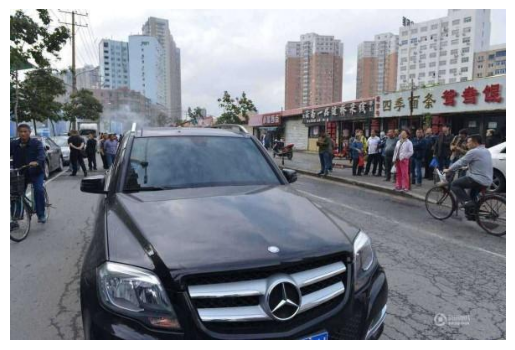

In [59]:
# 读取并显示
imgFile = './WiderPerson/Images/' + test_imgId + '.jpg'
# 复制到当前目录
shutil.copy(imgFile, './')
img = cv2.imread(imgFile)
plt.imshow(img[:,:,::-1])
plt.axis('off')

In [60]:
# 转为yolo格式
yoloLabelFile = convert2yolo(test_imgId, savePathPrefix='./')

In [ ]:
# 生成classes.txt，每行写入一个类别，0:pedestrians, 1:riders, 2:partially-visible persons, 3:ignore regions, 4:crowd
# 格式：0 pedestrians
with open('./classes.txt', 'w') as f:
    f.writelines(['0 pedestrians\n', '1 riders\n', '2 partially-visible persons\n', '3 ignore regions\n', '4 crowd\n'])

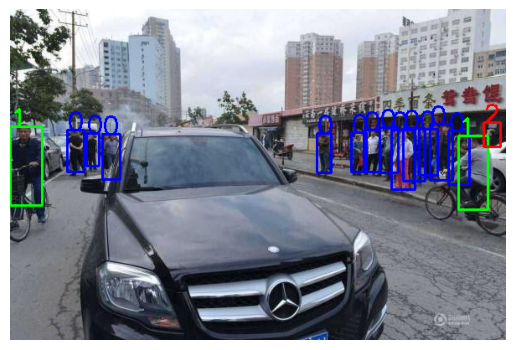

In [61]:
# 测试显示，也可以在LabelImg中查看
yoloDraw(img, yoloLabelFile)

In [62]:
# 要处理所有的图片

In [63]:
# 创建多级文件路径：./person_data/images/train, ./person_data/images/val, ./person_data/labels/train, ./person_data/labels/val
if not os.path.exists('./person_data'):
    os.mkdir('./person_data')
if not os.path.exists('./person_data/images'):
    os.mkdir('./person_data/images')
if not os.path.exists('./person_data/images/train'):
    os.mkdir('./person_data/images/train')
if not os.path.exists('./person_data/images/val'):
    os.mkdir('./person_data/images/val')

if not os.path.exists('./person_data/labels'):
    os.mkdir('./person_data/labels')
if not os.path.exists('./person_data/labels/train'):
    os.mkdir('./person_data/labels/train')
if not os.path.exists('./person_data/labels/val'):
    os.mkdir('./person_data/labels/val')


In [64]:
# 检查文件结构
! tree ./person_data

./person_data
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


In [65]:

# 获取所有训练图片的文件名
train_img_file_names = []
with open('./WiderPerson/train.txt', 'r') as f:
    train_img_file_names = f.readlines()
    train_img_file_names = [x.strip() for x in train_img_file_names]
# 获取所有验证图片的文件名
val_img_file_names = []
with open('./WiderPerson/val.txt', 'r') as f:
    val_img_file_names = f.readlines()
    val_img_file_names = [x.strip() for x in val_img_file_names]

In [66]:
# 打印文件数量
print('train_img_file_names:', len(train_img_file_names))
print('val_img_file_names:', len(val_img_file_names))

train_img_file_names: 8000
val_img_file_names: 1000


In [67]:
# 处理训练集
for img_file_name in tqdm.tqdm(train_img_file_names, desc='train'):
    # 转为yolo格式
    yoloLabelFile = convert2yolo(img_file_name, savePathPrefix='./person_data/labels/train/')
    if yoloLabelFile:
        # 复制图片到指定路径
        imgFile = './WiderPerson/Images/' + img_file_name + '.jpg'
        shutil.copy(imgFile, './person_data/images/train/' + img_file_name + '.jpg')
# 处理验证集
for img_file_name in tqdm.tqdm(val_img_file_names, desc='val'):
    # 转为yolo格式
    yoloLabelFile = convert2yolo(img_file_name, savePathPrefix='./person_data/labels/val/')
    if yoloLabelFile:
        # 复制图片到指定路径
        imgFile = './WiderPerson/Images/' + img_file_name + '.jpg'
        shutil.copy(imgFile, './person_data/images/val/' + img_file_name + '.jpg')        

val: 100%|██████████| 1000/1000 [00:04<00:00, 245.81it/s]


In [68]:
# 检查文件数量
print('train_img_file_names:', len(os.listdir('./person_data/images/train')))
print('val_img_file_names:', len(os.listdir('./person_data/images/val')))
print('train_label_file_names:', len(os.listdir('./person_data/labels/train')))
print('val_label_file_names:', len(os.listdir('./person_data/labels/val')))

train_img_file_names: 8000
val_img_file_names: 1000
train_label_file_names: 8000
val_label_file_names: 1000
